In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf # Needs lightgbm 4.5.0
import random
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [121]:
def split_by_time(data: pd.DataFrame) -> dict:
    # Split the data into time steps
    time_steps = data["t"].unique()
    data_by_time = {t: data[data["t"] == t].drop(columns=["t"]).to_numpy() for t in time_steps}

    return data_by_time

def compute_A_matrix(data: np.ndarray) -> np.ndarray:
    n = data.shape[0]
    # Inner product: each summation term is 1 if both values are 1, 0 otherwise
    return np.dot(data.T, data) / n

def graph_covariance(A: np.ndarray) -> np.ndarray:
    # Computing the diagonal of A is sufficient
    A_diag = np.diag(A)

    return A - np.outer(A_diag, A_diag)

In [122]:
def replace_with_nan(df, column_name, percentage):
    """
    Randomly replaces a specified percentage of values in a DataFrame column with NaN.

    Args:
        df (pd.DataFrame): The DataFrame.
        column_name (str): The name of the column to modify.
        percentage (float): The percentage of values to replace with NaN (0.0 to 1.0).

    Returns:
        pd.DataFrame: The modified DataFrame.
    """
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1")

    series = df[column_name].copy()
    num_to_replace = int(len(series) * percentage)
    random_indices = np.random.choice(series.index, num_to_replace, replace=False)
    series[random_indices] = np.nan
    df[column_name] = series
    return df


In [123]:
def median_impute(df):
    column_names = list(df.columns)

    for col in column_names:
        med = df[col].median()
        df[col] = df[col].fillna(med)
    return df

In [124]:
def mode_impute(df):
    column_names = list(df.columns)

    for col in column_names:
        mode = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode)

    return df

In [125]:
def locf_impute(df):
    for j in range(df.shape[1]):
        for i in range(df.shape[0]):
            # Assign median if in the first point in column
            if pd.isna(df.iloc[i,j]):
                if i == 0:
                    med = df.iloc[:,j].median()
                    df.iloc[i,j] = med
                elif i != 0 and not pd.isna(df.iloc[i-1,j]):
                    df.iloc[i,j] = df.iloc[i-1,j]

    return df

In [126]:
def lin_reg_impute(df, X, y: str):
    # Separate data into complete and incomplete cases
    complete_cases = df.dropna()
    missing_cases = df[df.isnull().any(axis=1)]

    # Fit the regression model on complete cases
    X_complete = complete_cases[X]
    y_complete = complete_cases[y]
    model = LinearRegression().fit(X_complete, y_complete)

    # Impute the missing values with mean
    imputer = SimpleImputer(strategy='median')
    data_copy = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Creata a DataFrame with imputed values
    # data_copy = pd.DataFrame(X_imputed, columns=X)
    # data_copy[y] = df[y]

    print(data_copy)
    return data_copy

In [127]:
def stochastic_reg_impute(df):
    data_copy = df.copy()
    
    for column in df.columns:
        missing_mask = df[column].isnull()
        if missing_mask.sum() == 0:
            continue  # Skip if no missing values
        
        # Define features (X) and target (y)
        X_train = df.loc[~missing_mask].drop(columns=[column])
        y_train = df.loc[~missing_mask, column]
        X_test = df.loc[missing_mask].drop(columns=[column])
        
        # Use mean imputation for missing values in predictors
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # Train a regression model
        model = LinearRegression()
        model.fit(X_train_imputed, y_train)
        
        # Predict missing values
        y_pred = model.predict(X_test_imputed)
        
        # Add stochastic noise based on training residuals
        residual_std = np.std(y_train - model.predict(X_train_imputed))
        noise = np.random.normal(0, residual_std, size=len(y_pred))
        y_pred_stochastic = y_pred + noise
        
        # Fill missing values with stochastic predictions
        data_copy.loc[missing_mask, column] = y_pred_stochastic
    
    return data_copy

In [128]:
def mice_impute(df):
    # Create kernels for MICE forest imputation
    kernel = mf.ImputationKernel(
      data=df,
      save_all_iterations=True,
      random_state=1343
    )
    # Run the MICE algorithm for 3 iterations on each of the datasets
    kernel.mice(3,verbose=True)
    completed_dataset = kernel.complete_data(dataset=0, inplace=False)
    return completed_dataset

In [129]:
def miss_forest_impute(df):
    imputer = MissForest()
    X_imputed = imputer.fit_transform(df)
    X_imputed = pd.DataFrame(X_imputed, columns = df.columns).round()

    return X_imputed

In [130]:
def knn_impute(df):
    # Create and fit the KNNImputer
    imputer = KNNImputer(n_neighbors=4)
    imputed_data = imputer.fit_transform(df)   
    df_kNN_imputed = pd.DataFrame(imputed_data, columns=df.columns).round()
    return df_kNN_imputed

In [202]:
def random_forest_imputation(df, iterations=5):
    """Imputes missing values in a DataFrame using Random Forest.

    Args:
        df (pd.DataFrame): The DataFrame with missing values.
        iterations (int, optional): Number of imputation iterations. Defaults to 5.

    Returns:
        pd.DataFrame: The DataFrame with imputed values.
    """
    df_imputed = df.copy()
    for _ in range(iterations):
        for col in df_imputed.columns:
            if df_imputed[col].isnull().any():
                temp_df = df_imputed.copy()
                
                # Use SimpleImputer for initial filling of NaN values
                imp = SimpleImputer(strategy='most_frequent')
                # imp = SimpleImputer(strategy='mean')
                temp_df[col] = imp.fit_transform(temp_df[[col]])
                
                # Split data into known and unknown
                known_data = temp_df[df_imputed[col].notna()]
                unknown_data = temp_df[df_imputed[col].isna()]

                train_data = known_data.drop(col, axis=1)
                train_target = known_data[col]
                test_data = unknown_data.drop(col, axis=1)
                
                # features = [c for c in temp_df.columns if c != col]

                # Train Random Forest Regressor
                hgb = HistGradientBoostingClassifier(random_state=0)
                hgb.fit(train_data, train_target)

                # Predict missing values
                predicted_values = hgb.predict(test_data)
                
                # Assign the predicted values to the original dataframe
                df_imputed.loc[df_imputed[col].isna(), col] = predicted_values
    return df_imputed

In [185]:
def shift_series(base_series, imputed_series):
    """
    Shift imputed_series so that its first value matches 
    the first value of base_series.
    """
    if np.any(base_series) == False:  # if empty
        return imputed_series
    offset = base_series[0] - imputed_series[0]
    return [val + offset for val in imputed_series]

def mean_squared_error(series1, series2):
    diff = np.array(series1) - np.array(series2)
    return np.mean(diff ** 2)

In [203]:
# Load data
data = pd.read_csv("simple_gen_data.csv")
# data

In [204]:
# Replace random elements with NaN based on CTDC percentages, then use median imputation to impute the 'missing' data
data_copy = data.drop('t', axis=1)

# Drop percentages based on percent Nan from first 7 columns of CTDC 2024 dataset
percent_to_drop = np.array([
    0.20145084842363767,
    0.4748657902346418,
    0.5116021775298698,
    0.21924490505785374,
    0.9072202967911189,
    0.8529119642610186,
    0.8260993466572234
])

i = 0
for col in list(data_copy.columns):
    data_copy = replace_with_nan(data_copy, col, percent_to_drop[i])
    i += 1

# Now, use imputation to impute the 'missing' data
data_copy = random_forest_imputation(data_copy)
data_copy.insert(0, 't', data['t'])

In [205]:
data = split_by_time(data)
data_copy = split_by_time(data_copy)

# Get adjacency for each timestep
adj_matrices = {t: compute_A_matrix(data[t]) for t in data}
adj_matrices_med_imp = {t: compute_A_matrix(data_copy[t]) for t in data_copy}

# Get graph covariances for each timestep
graph_cov = {t: graph_covariance(adj_matrices[t]) for t in adj_matrices}
graph_cov_med_imp = {t: graph_covariance(adj_matrices_med_imp[t]) for t in adj_matrices_med_imp}

graph_covariances_over_time = np.array([graph_cov[t][0, :] for t in sorted(list(graph_cov.keys()))])[:, 1:]
graph_covariances_over_time_med_imp = np.array([graph_cov_med_imp[t][0, :] for t in sorted(list(graph_cov_med_imp.keys()))])[:, 1:]

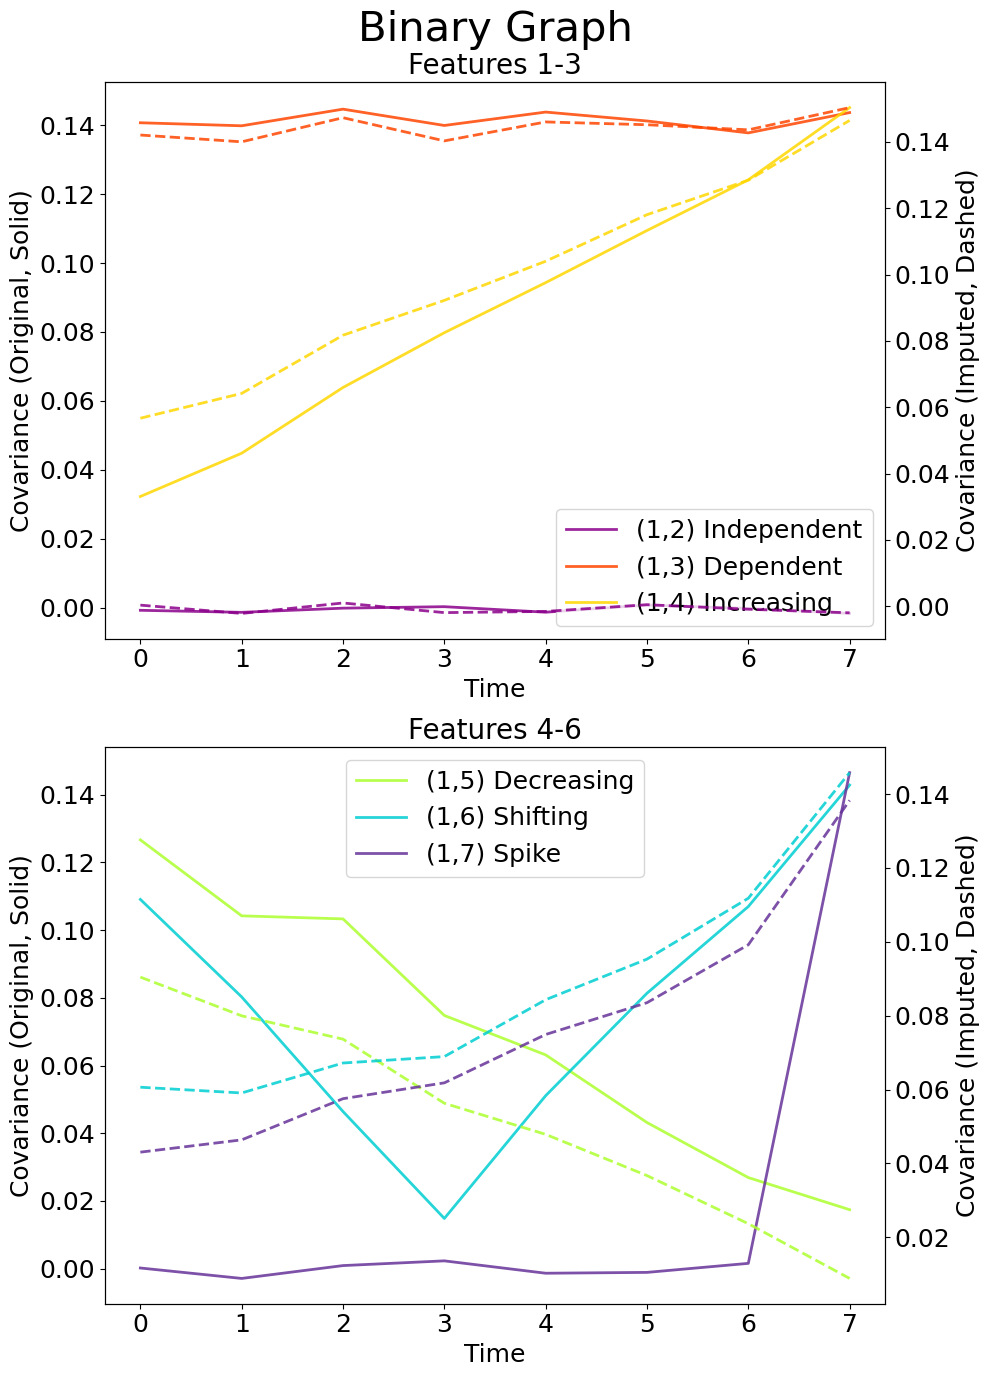

In [206]:
# Time to plot!

legend_labels = [
    "(1,2) Independent", 
    "(1,3) Dependent", 
    "(1,4) Increasing", 
    "(1,5) Decreasing", 
    "(1,6) Shifting", 
    "(1,7) Spike"
]

colors = [
    "darkmagenta",
    "orangered",
    "gold",
    "greenyellow",
    "darkturquoise",
    "rebeccapurple"
]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14), sharey=False)
ax1_alt = ax1.twinx()
ax2_alt = ax2.twinx()

# Define increased font sizes
title_fontsize = 20
label_fontsize = 18
legend_fontsize = 18
tick_fontsize = 18

# Plot the first 3 features in the left subplot
for i in range(3):
    ax1.plot(graph_covariances_over_time[:, i],
            label=legend_labels[i],
            linewidth=2,
            color=colors[i],
            alpha=0.85)
    ax1_alt.plot(graph_covariances_over_time_med_imp[:, i],
            '--',
            label=legend_labels[i] + " (Imputed)",
            linewidth=2,
            color=colors[i],
            alpha=0.85)
ax1.set_title("Features 1-3", fontsize=title_fontsize)
ax1.set_xlabel("Time", fontsize=label_fontsize)
ax1.set_ylabel("Covariance (Original, Solid)", fontsize=label_fontsize)
ax1.legend(loc="lower right", fontsize=legend_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax1.grid(True)

ax1_alt.set_ylabel("Covariance (Imputed, Dashed)", fontsize=label_fontsize)
# ax1_alt.legend(loc="best", fontsize=legend_fontsize)
ax1_alt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax1_alt.grid(True)

# Plot the last 3 features in the right subplot
for i in range(3, 6):
    ax2.plot(graph_covariances_over_time[:, i],
            label=legend_labels[i],
            linewidth=2,
            color=colors[i],
            alpha=0.85)
    ax2_alt.plot(graph_covariances_over_time_med_imp[:, i],
            '--',
            label=legend_labels[i] + " (Imputed)",
            linewidth=2,
            color=colors[i],
            alpha=0.85)
ax2.set_title("Features 4-6", fontsize=title_fontsize)
ax2.set_xlabel("Time", fontsize=label_fontsize)
ax2.set_ylabel("Covariance (Original, Solid)", fontsize=label_fontsize)
ax2.legend(loc="best", fontsize=legend_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax2.grid(True)

ax2_alt.set_ylabel("Covariance (Imputed, Dashed)", fontsize=label_fontsize)
# ax2_alt.legend(loc="best", fontsize=legend_fontsize)
ax2_alt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax2_alt.grid(True)

fig.suptitle("Binary Graph", fontsize=title_fontsize*1.5)
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [223]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error as mse
from scipy.stats import pearsonr

In [225]:
# Load data
data = pd.read_csv("simple_gen_data.csv")
# data

In [226]:
# Replace random elements with NaN based on CTDC percentages, then use median imputation to impute the 'missing' data
data_copy = data.drop('t', axis=1)

# Drop percentages based on percent Nan from first 7 columns of CTDC 2024 dataset
percent_to_drop = np.array([
    0.20145084842363767,
    0.4748657902346418,
    0.5116021775298698,
    0.21924490505785374,
    0.9072202967911189,
    0.8529119642610186,
    0.8260993466572234
])

i = 0
for col in list(data_copy.columns):
    data_copy = replace_with_nan(data_copy, col, percent_to_drop[i])
    i += 1

# Now, use imputation to impute the 'missing' data
# Use X and y for linear regression imputation only
X = ['X2', 'X3', 'X4', 'X5', 'X6', 'X7']
y = 'X1'
data_copy = random_forest_imputation(data_copy)
if data_copy.columns[-1] == 'X1':
    cols = list(data_copy)
    cols.insert(0, cols.pop(cols.index('X1')))

    data_copy = data_copy.loc[:, cols]
data_copy.insert(0, 't', data['t'])

In [227]:
cols = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7']

assert data.shape[0] == data_copy.shape[0], "Dataframes do not have the same number of rows"
assert all(data['t'] == data_copy['t']), "The time columns do not match row by row"

In [228]:
print("Percentage of 0s and 1s in original dataset (per variable):")
for col in cols:
    pct_0 = (data[col] == 0).mean() * 100
    pct_1 = (data[col] == 1).mean() * 100
    print(f"{col}: 0 -> {pct_0:.2f}%, 1 -> {pct_1:.2f}%")

Percentage of 0s and 1s in original dataset (per variable):
X1: 0 -> 80.40%, 1 -> 19.60%
X2: 0 -> 89.94%, 1 -> 10.05%
X3: 0 -> 82.41%, 1 -> 17.59%
X4: 0 -> 89.21%, 1 -> 10.79%
X5: 0 -> 91.30%, 1 -> 8.70%
X6: 0 -> 90.16%, 1 -> 9.84%
X7: 0 -> 88.91%, 1 -> 11.09%


In [232]:
y_true = data[cols].values.flatten()      # Flatten 2D array into 1D
y_imputed = np.round(data_copy[cols].values.flatten()).astype(int)

global_pearson = pearsonr(y_true, y_imputed)[0]
global_nmse = mse(y_true, y_imputed)/1.0 #np.var(y_true)
global_nmae = mean_absolute_error(y_true, y_imputed)/1.0 #np.mean(y_true)

print("Global Metrics (all X columns combined):")
print(f"Pearson R:               {global_pearson:.3f}")
print(f"NMSE:                    {global_nmse:.3f}")
print(f"NMAE:                    {global_nmae:.3f}")
print(f"1 - NMSE:                {1 - global_nmse:.3f}")
print(f"1 - NMAE:                {1 - global_nmae:.3f}")

Global Metrics (all X columns combined):
Pearson R:               0.743
NMSE:                    0.055
NMAE:                    0.055
1 - NMSE:                0.945
1 - NMAE:                0.945


In [173]:
print("\nPer-Column Metrics:")
for col in cols:
    col_accuracy = accuracy_score(data[col], data_copy[col])
    col_precision = precision_score(data[col], data_copy[col], zero_division=0)
    col_recall = recall_score(data[col], data_copy[col], zero_division=0)
    col_f1 = f1_score(data[col], data_copy[col], zero_division=0)
    
    print(f"Column: {col}")
    print(f"  Accuracy:  {col_accuracy:.3f}")
    print(f"  Precision: {col_precision:.3f}")
    print(f"  Recall:    {col_recall:.3f}")
    print(f"  F1-Score:  {col_f1:.3f}")
    print("")


Per-Column Metrics:
Column: X1
  Accuracy:  0.989
  Precision: 1.000
  Recall:    0.943
  F1-Score:  0.970

Column: X2
  Accuracy:  0.953
  Precision: 1.000
  Recall:    0.528
  F1-Score:  0.691

Column: X3
  Accuracy:  0.981
  Precision: 0.947
  Recall:    0.947
  F1-Score:  0.947

Column: X4
  Accuracy:  0.981
  Precision: 0.870
  Recall:    0.964
  F1-Score:  0.914

Column: X5
  Accuracy:  0.928
  Precision: 0.615
  Recall:    0.456
  F1-Score:  0.524

Column: X6
  Accuracy:  0.919
  Precision: 0.556
  Recall:    0.862
  F1-Score:  0.676

Column: X7
  Accuracy:  0.863
  Precision: 0.388
  Recall:    0.404
  F1-Score:  0.396



In [174]:
data = split_by_time(data)
data_copy = split_by_time(data_copy)

# Get adjacency for each timestep
adj_matrices = {t: compute_A_matrix(data[t]) for t in data}
adj_matrices_med_imp = {t: compute_A_matrix(data_copy[t]) for t in data_copy}

# Get graph covariances for each timestep
graph_cov = {t: graph_covariance(adj_matrices[t]) for t in adj_matrices}
graph_cov_med_imp = {t: graph_covariance(adj_matrices_med_imp[t]) for t in adj_matrices_med_imp}

graph_covariances_over_time = np.array([graph_cov[t][0, :] for t in sorted(list(graph_cov.keys()))])[:, 1:]
graph_covariances_over_time_med_imp = np.array([graph_cov_med_imp[t][0, :] for t in sorted(list(graph_cov_med_imp.keys()))])[:, 1:]

In [177]:
gc_matrices1 = graph_covariances_over_time
gc_matrices2 = graph_covariances_over_time_med_imp

# times1 = sorted(gc_matrices1.keys())
# times2 = sorted(gc_matrices2.keys())
# common_times = sorted(set(times1) & set(times2))

# gc1_12 = [gc_matrices1[t].loc["X1","X2"] for t in common_times] if common_times else []
# gc1_13 = [gc_matrices1[t].loc["X1","X3"] for t in common_times] if common_times else []
# gc1_14 = [gc_matrices1[t].loc["X1","X4"] for t in common_times] if common_times else []
# gc1_15 = [gc_matrices1[t].loc["X1","X5"] for t in common_times] if common_times else []
# gc1_16 = [gc_matrices1[t].loc["X1","X6"] for t in common_times] if common_times else []
# gc1_17 = [gc_matrices1[t].loc["X1","X7"] for t in common_times] if common_times else []

gc1_12 = gc_matrices1[:, 0]
gc1_13 = gc_matrices1[:, 1]
gc1_14 = gc_matrices1[:, 2]
gc1_15 = gc_matrices1[:, 3]
gc1_16 = gc_matrices1[:, 4]
gc1_17 = gc_matrices1[:, 5]

# gc2_12 = [gc_matrices2[t].loc["X1","X2"] for t in common_times] if common_times else []
# gc2_13 = [gc_matrices2[t].loc["X1","X3"] for t in common_times] if common_times else []
# gc2_14 = [gc_matrices2[t].loc["X1","X4"] for t in common_times] if common_times else []
# gc2_15 = [gc_matrices2[t].loc["X1","X5"] for t in common_times] if common_times else []
# gc2_16 = [gc_matrices2[t].loc["X1","X6"] for t in common_times] if common_times else []
# gc2_17 = [gc_matrices2[t].loc["X1","X7"] for t in common_times] if common_times else []

gc2_12 = gc_matrices2[:, 0]
gc2_13 = gc_matrices2[:, 1]
gc2_14 = gc_matrices2[:, 2]
gc2_15 = gc_matrices2[:, 3]
gc2_16 = gc_matrices2[:, 4]
gc2_17 = gc_matrices2[:, 5]

gc2_12_shifted = shift_series(gc1_12, gc2_12)
gc2_13_shifted = shift_series(gc1_13, gc2_13)
gc2_14_shifted = shift_series(gc1_14, gc2_14)
gc2_15_shifted = shift_series(gc1_15, gc2_15)
gc2_16_shifted = shift_series(gc1_16, gc2_16)
gc2_17_shifted = shift_series(gc1_17, gc2_17)

pairs_original = [gc1_12, gc1_13, gc1_14, gc1_15, gc1_16, gc1_17]
pairs_imputed  = [gc2_12_shifted, gc2_13_shifted, gc2_14_shifted,
                  gc2_15_shifted, gc2_16_shifted, gc2_17_shifted]
pair_names = ["Independent (X1,X2)", "Dependent (X1,X3)", "Increasing (X1,X4)", 
              "Decreasing (X1,X5)", "Shifting (X1,X6)", "Spiking (X1,X7)"]

mse_values = []
for orig_series, imp_series, name in zip(pairs_original, pairs_imputed, pair_names):
    if len(orig_series) == 0 or len(imp_series) == 0:
        print(f"\nNo data for pair {name}; cannot compute MSE.")
        mse_values.append(np.nan)
        continue
    
    mse_val = mean_squared_error(orig_series, imp_series)
    mse_values.append(mse_val)
    print(f"MSE for {name}: {mse_val:.4f}")

# Report overall average MSE across all pairs
similarity_values = []
for orig_series, imp_series, name in zip(pairs_original, pairs_imputed, pair_names):
    if len(orig_series) == 0 or len(imp_series) == 0:
        print(f"\nNo data for pair {name}; cannot compute 1 - MSE.")
        similarity_values.append(np.nan)
        continue
    
    mse_val = mean_squared_error(orig_series, imp_series)
    similarity = 1 - mse_val   # 1 - MSE
    similarity_values.append(similarity)
    
    print(f"1 - MSE for {name}: {similarity:.4f}")

# Overall average of (1 - MSE) across all pairs
valid_sims = [val for val in similarity_values if not np.isnan(val)]
if len(valid_sims) > 0:
    avg_similarity = np.mean(valid_sims)
    print(f"\nAverage (1 - MSE) across all pairs: {avg_similarity:.4f}")
else:
    print("\nNo valid (1 - MSE) values to average.")

MSE for Independent (X1,X2): 0.0000
MSE for Dependent (X1,X3): 0.0000
MSE for Increasing (X1,X4): 0.0002
MSE for Decreasing (X1,X5): 0.0005
MSE for Shifting (X1,X6): 0.0015
MSE for Spiking (X1,X7): 0.0011
1 - MSE for Independent (X1,X2): 1.0000
1 - MSE for Dependent (X1,X3): 1.0000
1 - MSE for Increasing (X1,X4): 0.9998
1 - MSE for Decreasing (X1,X5): 0.9995
1 - MSE for Shifting (X1,X6): 0.9985
1 - MSE for Spiking (X1,X7): 0.9989

Average (1 - MSE) across all pairs: 0.9995
